In [88]:
import sys
sys.path.insert(0, '/Users/abrahamn/21cmIR/21cmIRxcor/')
import mwa_utils

In [89]:
import pickle
import numpy as np
from numpy import pi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [90]:
# MWA uv space sampling
analysis_root = '/Volumes/abraham/xcor_data/analysis/21cmfreqavgcubes/'
fhddeeplabel = 'Combined_obs_wedge_cut_plus_res_cut'
mwa_deep_image = pickle.load( open( analysis_root+fhddeeplabel+'.p', "rb" ) )

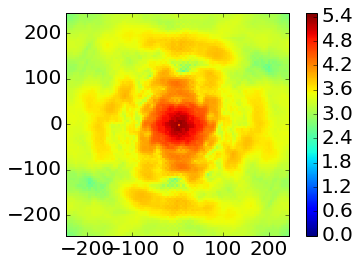

In [164]:
# the total obs time in each uv cell is proportional to weights_uv
weights_uv = np.abs(np.fft.fft2(mwa_deep_image.weights_xx0))

t_hours = 3.
#t_hours = 500.
t_obs_21_sec = t_hours*3600.

Nant = 112 # 128 MWA ants minus 16 outriggers
num_baselines = Nant*(Nant-1)/2
num_seconds_per_uv = weights_uv/np.sum(weights_uv)*np.sum(num_baselines*t_obs_21_sec)

lamda = 300./185
du = 1./(mwa_deep_image.n*mwa_deep_image.dtheta_rad)
umax = du*mwa_deep_image.n/2

plt.imshow(np.log10(np.fft.fftshift(num_seconds_per_uv)),interpolation='nearest',vmin=0,vmax=5.5,extent=[-umax,umax,-umax,umax])
plt.colorbar()

In [92]:
# cosmology
from cosmocalc import cosmocalc
WM,WV = 0.27,0.73
c = 3.e8
h = 6.626e-34 # J*sec
c_over_H0_Mpc = 4283.

In [132]:
# experimental params
z = 7.
Deltaz = 1.5

Ez = np.sqrt(WM*(1+z)**3+WV)

D = cosmocalc(z,WM=WM,WV=WV)['DCMR_Mpc']
DeltaD = c_over_H0_Mpc*Deltaz/Ez
wedgeslope = D*Ez/(c_over_H0_Mpc*(1+z))*(pi/2)

In [133]:
# perp sampling
theta_fov_rad = mwa_deep_image.n*mwa_deep_image.dtheta_rad
dtheta_rad = mwa_deep_image.dtheta_rad
Nperp = mwa_deep_image.n

In [134]:
# IR expt
lamda0_IR_m = 120.e-9

R_IR = 40.
dz = (1+z)/R_IR
Nf = int(Deltaz / dz)

B_IR = Deltaz*c/lamda0_IR_m/(1+z)**2

In [135]:
# 21cm expt
f0_21_Hz = 1420.e6
B_Hz = Deltaz*f0_21_Hz/(1+z)**2

In [136]:
dkpara = 2.*pi/DeltaD
kparamax = Nf/2*dkpara

dkperp = 2.*pi/(theta_fov_rad*D)
kperpmax = Nperp/2*dkperp

kparavals = np.fft.fftfreq(Nf)*Nf*dkpara
kperpvals = np.fft.fftfreq(Nperp)*Nperp*dkperp
kzgrid,kxgrid,kygrid = np.meshgrid(kparavals,kperpvals,kperpvals,indexing='ij')

kperpgrid = np.sqrt(kxgrid**2+kygrid**2)
kmaggrid = np.sqrt(kxgrid**2+kygrid**2+kzgrid**2)
inwindow = kzgrid > wedgeslope*kperpgrid

In [178]:
# 21cm thermal noise
# https://www.evernote.com/shard/s316/nl/2147483647/6f7c9ac4-f872-407d-89e3-acb8fdff1982/
    
Tsky_K = 400.
A_21 = 20. # m^2
B_Hz = 30.e6 # MHz
P_21_thermal = (Tsky_K**2)*(lamda**2)*(D**2)*DeltaD/(B_Hz*A)/num_seconds_per_uv

P_21_thermal_veck = np.repeat([P_21_thermal],Nf,axis=0)

In [177]:
# IR shot noise
# https://www.evernote.com/shard/s316/nl/2147483647/89eb8fb1-82bf-46c2-a07a-4c81d1fd171b/

# https://www.evernote.com/shard/s316/nl/2147483647/0b490f35-5419-452a-9350-371cc062850b/
kjy = 1000 * 1.e-26
Isky = 1.6 # kJy/sr 
hf = h*c/(lamda0_IR_m*(1+z))
t_obs_ir_sec = 15.
A_IR = .5**2 # m^2
P_IR_shot = D**2*DeltaD*hf*Isky/(B_IR*t_obs_ir_sec*A_IR*kjy)

P_IR_shot_veck = np.tile(P_IR_shot,(Nf,Nperp,Nperp))

(array([   461.,   3074.,   5592.,   7840.,  10152.,  12256.,  14528.,
         10062.,   4680.,   1355.]),
 array([ 0.        ,  0.02498794,  0.04997588,  0.07496381,  0.09995175,
         0.12493969,  0.14992763,  0.17491556,  0.1999035 ,  0.22489144,
         0.24987938]),
 <a list of 10 Patch objects>)

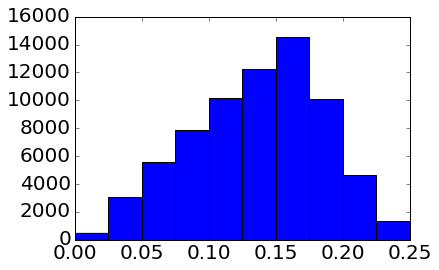

In [137]:
plt.hist(kmaggrid.flatten())

In [153]:
def bin_noise_to_1D(P1_veck,P2_veck,nbins=5,kmax=.1,wedgecut=False):
    kbinedges = np.linspace(0,kmax,nbins+1)
    kbincenters = .5*(kbinedges[0:nbins]+kbinedges[1:nbins+1])

    P_binned = np.zeros(nbins)
    P_binned_wedgecut = np.zeros(nbins)
    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (kmaggrid>kbinedges[bini])&(kmaggrid<kbinedges[bini+1])
        if wedgecut: inbin &= inwindow
    
        bin_counts[bini] = np.sum(inbin)
        P_binned[bini] = np.sqrt(1./(np.sum( 1./(P1_veck[inbin]*P2_veck[inbin]) )))
        
    return kbincenters,P_binned,bin_counts

In [154]:
# load Gong theoretical values
gongdat = np.genfromtxt('gong_lyalpha_model_pspec_z=7.csv',delimiter=',')
gong_k = gongdat[:,0]
gong_Delta_kjy_per_sr = np.sqrt(gongdat[:,1])*1.e-3

gongdat = np.genfromtxt('gong_lyalpha_model_pspec_upperlimit_z=7.csv',delimiter=',')
gong_k_upper = gongdat[:,0]
gong_Delta_kjy_per_sr_upperlimit = np.sqrt(gongdat[:,1])*1.e-3

gongdat = np.genfromtxt('gong_lyalpha_model_pspec_lowerlimit_z=7.csv',delimiter=',')
gong_k_lower = gongdat[:,0]
gong_Delta_kjy_per_sr_lowerlimit = np.sqrt(gongdat[:,1])*1.e-3

In [155]:
# load vanilla 21cmFAST power spectrum from Pober 14 (what can 21cm observatories teach us about reionization?)
poberdat = np.genfromtxt('pober_21cm_model_pspec_vanilla_z=8.csv',delimiter=',')
pober_k = poberdat[:,0]
pober_Delta_K = np.sqrt(poberdat[:,1])*1.e-3

In [156]:
# let's interpolate all these models onto the pober k

gong_Delta_kjy_per_sr_pober_k = np.interp(pober_k,gong_k,gong_Delta_kjy_per_sr)
gong_Delta_kjy_per_sr_upperlimit_pober_k = np.interp(pober_k,gong_k_upper,gong_Delta_kjy_per_sr_upperlimit)
gong_Delta_kjy_per_sr_lowerlimit_pober_k = np.interp(pober_k,gong_k_lower,gong_Delta_kjy_per_sr_lowerlimit)

/Users/abrahamn/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars


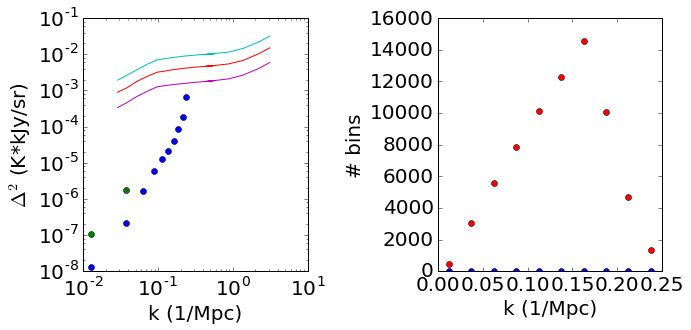

In [157]:
matplotlib.rcParams.update({'font.size': 20})

nbins = 10
kmax = np.max(kmaggrid)
kbincenters,P_binned,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_21_thermal_veck,nbins,kmax,wedgecut=False)
kbincenters,P_binned_wedgecut,bin_counts_wedgecut = bin_noise_to_1D(P_IR_shot_veck,P_21_thermal_veck,nbins,kmax,wedgecut=True)

plt.figure(figsize=(10,5))
    
plt.subplot(121)
plt.loglog(kbincenters,kbincenters**3/(2*pi**2)*P_binned,'o')
plt.loglog(kbincenters,kbincenters**3/(2*pi**2)*P_binned_wedgecut,'o')

plt.loglog(pober_k,np.sqrt(pober_Delta_K*gong_Delta_kjy_per_sr_pober_k),'-')
plt.loglog(pober_k,np.sqrt(pober_Delta_K*gong_Delta_kjy_per_sr_upperlimit_pober_k),'-')
plt.loglog(pober_k,np.sqrt(pober_Delta_K*gong_Delta_kjy_per_sr_lowerlimit_pober_k),'-')

plt.xlabel('k (1/Mpc)')
plt.ylabel(r'$\Delta^2$ (K*kJy/sr)')

plt.subplot(122)
plt.plot(kbincenters,bin_counts,'ro')
plt.plot(kbincenters,bin_counts_wedgecut,'bo')
plt.xlabel('k (1/Mpc)')
plt.ylabel('# bins')

plt.tight_layout()

In [158]:
# load the beardsley EOR theory curve
print(open('beardsley_eor_theory.csv').readlines()[:2])
beardsleydat = np.genfromtxt('beardsley_eor_theory.csv',delimiter=',')
beardsley_eor_k = beardsleydat[:,0]
T0 = 26.e-3
DeltaSquared_beardsley_eor = beardsleydat[:,1]*T0**2

['# k, Delta^2 (mK)\n', "# big blue points in Fig. 4 of Adam's sensitivity paper\n"]


In [159]:
# load the beardsley MWA sensitivity calculations
print(open('beardsley_MWA_450hour_sensitivity.csv').readlines()[:2])
beardsleymwadat = np.genfromtxt('beardsley_MWA_450hour_sensitivity.csv',delimiter=',')
beardsley_mwa_k = beardsleymwadat[:,0]
DeltaSquared_beardsley_mwa = beardsleymwadat[:,1]*T0**2

['# k, Delta^2 (mK)\n', "# green line in Fig. 4 of Adam's sensitivity paper\n"]


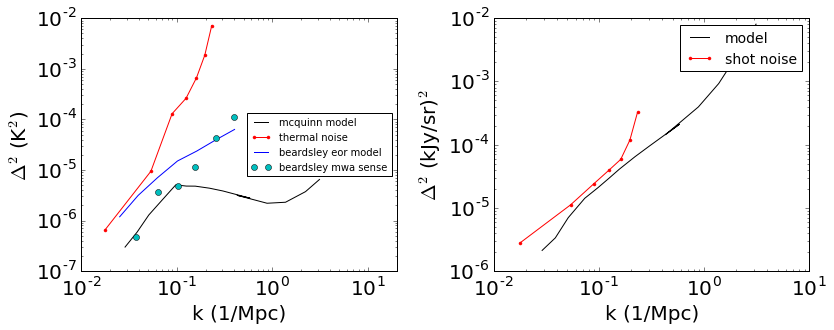

In [161]:
# what about auto spectra sensitivity?

kbincenters,P_21_binned,bin_counts = bin_noise_to_1D(P_21_thermal_veck,P_21_thermal_veck,7,np.max(kmaggrid),wedgecut=False)
kbincenters,P_IR_binned,bin_counts = bin_noise_to_1D(P_IR_shot_veck,P_IR_shot_veck,7,np.max(kmaggrid),wedgecut=False)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.loglog(pober_k,pober_Delta_K**2,'k-',label='mcquinn model')
plt.loglog(kbincenters,kbincenters**2/(2*pi**2)*P_21_binned,'r.-',label='thermal noise')
plt.loglog(beardsley_eor_k,DeltaSquared_beardsley_eor,'b-',label='beardsley eor model')
plt.loglog(beardsley_mwa_k,DeltaSquared_beardsley_mwa,'co',label='beardsley mwa sense')
plt.legend(fontsize=10,loc=5)
plt.xlabel('k (1/Mpc)')
plt.ylabel(r'$\Delta^2$ (K$^2$)')
plt.xlim([.01,20])

plt.subplot(122)
plt.loglog(pober_k,gong_Delta_kjy_per_sr_pober_k**2,'k-',label='model')
plt.loglog(kbincenters,kbincenters**2/(2*pi**2)*P_IR_binned,'r.-',label='shot noise')
plt.legend(fontsize=14)
plt.xlabel('k (1/Mpc)')
plt.ylabel(r'$\Delta^2$ (kJy/sr)$^2$')
plt.tight_layout()

In [ ]:
def draw_2D_kspace(z,Deltaz,Nf,theta_fov_rad,Nperp,col):
    WM,WV = 0.27,0.73
    Ez = np.sqrt(WM*(1+z)**3+WV)
    
    D = cosmocalc(z,WM=WM,WV=WV)['DCMR_Mpc']
    DeltaD = c_over_H0_Mpc*Deltaz/Ez
    
    dkpara = 2.*pi/DeltaD
    kparamax = Nf/2*dkpara

    dkperp = 2.*pi/(theta_fov_rad*D)
    kperpmax = Nperp/2*dkperp

    wedgeslope = D*Ez/(c_over_H0_Mpc*(1+z))*(pi/2)
    
    plt.loglog([dkperp,kperpmax,kperpmax,dkperp,dkperp],[dkpara,dkpara,kparamax,kparamax,dkpara],col,lw=2)
    
    for i in range(min(Nf/2,10)):
        plt.plot([dkperp,kperpmax],[i*dkpara,i*dkpara],col+'-',lw=1)
    for j in range(10):
        plt.plot([j*dkperp,j*dkperp],[dkpara,kparamax],col+'-',lw=1)
    
    plt.loglog([1.e-4,1.e4],[1.e-4*wedgeslope,1.e4*wedgeslope],'k',lw=2)

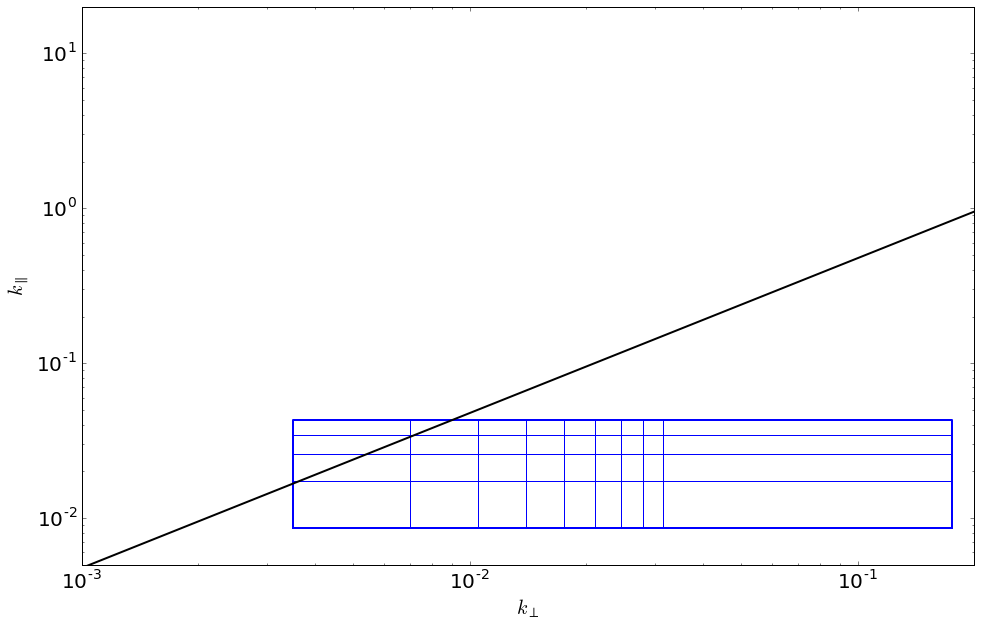

In [80]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(16,10))

draw_2D_kspace(z,Deltaz,Nf,theta_fov_rad,Nperp,'b')

plt.ylim([.005,20])
plt.xlim([.001,.2])
plt.ylabel(r'$k_\parallel$')
plt.xlabel(r'$k_\perp$')